In [1]:
# --- Setup & imports ---
import random, os
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Makes CUDA deterministic (slightly slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
# # --- Transforms for ResNet pretrained on ImageNet ---
# IMAGENET_MEAN = [0.485, 0.456, 0.406] # MNIST is 1x28x28; ResNet expects 3x224x224 + ImageNet normalization.
# IMAGENET_STD  = [0.229, 0.224, 0.225]

# transform_train = transforms.Compose([
#     transforms.Resize(224),
#     transforms.Grayscale(num_output_channels=3),      # Convert MNIST to RGB
#     transforms.RandomHorizontalFlip(p=0.1),           # light augmentation
#     transforms.ToTensor(),
#     transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(224),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.ToTensor(),
#     transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
# ])


In [ ]:
# # --- Download the official MNIST splits ---
# train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
# test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# # Combine to 70,000 samples, then split by ratio 70:15:15 ---
# full_dataset = ConcatDataset([train_dataset, test_dataset])  # total = 60k + 10k = 70k
# n = len(full_dataset)                                   # 70,000
# train_size = int(0.70 * n)                              # 49,000
# val_size   = int(0.15 * n)                              # 10,500
# test_size  = n - train_size - val_size                  # 10,500

# train_set, val_set, test_set = random_split(
#     full_dataset, [train_size, val_size, test_size],
#     generator=torch.Generator().manual_seed(42)
# )

# print(f"Split sizes -> train: {len(train_set)} | val: {len(val_set)} | test: {len(test_set)}")


In [2]:
# NEW: keep transforms separate
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

transform_eval = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# NEW: load raw (no transform)
raw_train = datasets.MNIST(root="./data", train=True,  download=True, transform=None)
raw_test  = datasets.MNIST(root="./data", train=False, download=True, transform=None)

from torch.utils.data import ConcatDataset, Dataset
full_raw = ConcatDataset([raw_train, raw_test])  # 70k raw samples

# NEW: deterministic 70/15/15 split on indices (not on already-transformed data)
n = len(full_raw)
train_size = int(0.70 * n)
val_size   = int(0.15 * n)
test_size  = n - train_size - val_size
gen = torch.Generator().manual_seed(42)
train_idx, val_idx, test_idx = torch.utils.data.random_split(range(n), [train_size, val_size, test_size], generator=gen)

# NEW: tiny wrapper to apply a transform to a Subset of raw data
class TransformingSubset(Dataset):
    def __init__(self, base_concat, indices_subset, transform):
        self.base = base_concat
        self.indices = indices_subset.indices  # Subset of indices
        self.transform = transform
    def __len__(self): return len(self.indices)
    def __getitem__(self, i):
        img, label = self.base[self.indices[i]]  # returns (PIL, label) because base has transform=None
        img = self.transform(img)
        return img, label

# NEW: build properly transformed subsets
train_set = TransformingSubset(full_raw, train_idx, transform_train)
val_set   = TransformingSubset(full_raw, val_idx,   transform_eval)
test_set  = TransformingSubset(full_raw, test_idx,  transform_eval)


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


In [3]:
# --- DataLoaders ---
BATCH = 64
NUM_WORKERS = 2

train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

for name, ld in [("train", train_loader), ("val", val_loader), ("test", test_loader)]:
    print(f"{name:>5} | batches: {len(ld)} | samples: {len(ld.dataset)}")

train | batches: 766 | samples: 49000
  val | batches: 165 | samples: 10500
 test | batches: 165 | samples: 10500


Labels: [3, 4, 6, 9, 4, 4, 7, 0]


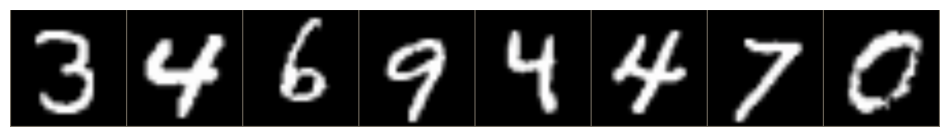

In [4]:
# --- De-normalize for visualization ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
inv_mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
inv_std  = torch.tensor(IMAGENET_STD).view(3,1,1)

def denorm(img_tensor):
    return img_tensor * inv_std + inv_mean  # reverse ImageNet normalization

def show_batch(dataloader, max_n=8):
    imgs, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(imgs[:max_n], nrow=max_n)
    grid = denorm(grid).clamp(0, 1)         # back to [0,1] for display
    plt.figure(figsize=(max_n*1.5, 1.8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    print("Labels:", labels[:max_n].tolist())

# Peek at validation images
show_batch(val_loader, max_n=8)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Safety: pick up device from earlier or set it here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all backbone params
for p in model.parameters():
    p.requires_grad = False

# Replace classification head (10 classes for MNIST)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, 10)

model = model.to(device)

# Only train the new head
params_to_train = [p for p in model.parameters() if p.requires_grad]
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_train, lr=1e-3, weight_decay=1e-4)

# Optional: a gentle scheduler (on val loss)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [6]:
from collections import defaultdict
import numpy as np
import math
import time

def run_one_epoch(loader, train_mode=True):
    model.train(train_mode)
    total, correct, loss_sum = 0, 0, 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        with torch.set_grad_enabled(train_mode):
            logits = model(xb)
            loss = criterion(logits, yb)

            if train_mode:
                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

        loss_sum += loss.item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        total    += xb.size(0)

    avg_loss = loss_sum / total
    acc = correct / total
    return avg_loss, acc

history = defaultdict(list)

EPOCHS = 10  # linear probe converges quickly on MNIST
best_val_loss = float('inf')
best_state = None

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    tr_loss, tr_acc = run_one_epoch(train_loader, train_mode=True)
    va_loss, va_acc = run_one_epoch(val_loader,   train_mode=False)

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(va_loss)
    history['val_acc'].append(va_acc)

    if scheduler is not None:
        scheduler.step(va_loss)

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    dt = time.time() - t0
    print(f"Epoch {epoch:02d} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val loss {va_loss:.4f} acc {va_acc:.4f} | "
          f"{dt:.1f}s")


Epoch 01 | train loss 0.4719 acc 0.8792 | val loss 0.2168 acc 0.9427 | 111.1s
Epoch 02 | train loss 0.2300 acc 0.9327 | val loss 0.1763 acc 0.9489 | 110.8s
Epoch 03 | train loss 0.1956 acc 0.9414 | val loss 0.1499 acc 0.9570 | 104.3s
Epoch 04 | train loss 0.1794 acc 0.9443 | val loss 0.1551 acc 0.9519 | 105.7s
Epoch 05 | train loss 0.1702 acc 0.9465 | val loss 0.1310 acc 0.9613 | 105.2s
Epoch 06 | train loss 0.1613 acc 0.9488 | val loss 0.1295 acc 0.9591 | 106.2s
Epoch 07 | train loss 0.1532 acc 0.9504 | val loss 0.1226 acc 0.9620 | 106.9s
Epoch 08 | train loss 0.1490 acc 0.9520 | val loss 0.1268 acc 0.9598 | 107.4s
Epoch 09 | train loss 0.1477 acc 0.9515 | val loss 0.1256 acc 0.9604 | 105.9s
Epoch 10 | train loss 0.1445 acc 0.9548 | val loss 0.1219 acc 0.9633 | 105.1s


In [7]:
# Restore best validation model before testing
if best_state is not None:
    model.load_state_dict(best_state)

# Test evaluation
test_loss, test_acc = run_one_epoch(test_loader, train_mode=False)
print(f"\n[Linear probe] Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")



[Linear probe] Test loss: 0.1309 | Test acc: 0.9570



Classification report (per class):
              precision    recall  f1-score   support

           0     0.9776    0.9887    0.9831      1060
           1     0.9909    0.9882    0.9895      1100
           2     0.9266    0.9579    0.9420      1068
           3     0.9313    0.9244    0.9278      1071
           4     0.9773    0.9602    0.9687      1031
           5     0.9454    0.8706    0.9065       935
           6     0.9678    0.9796    0.9737       981
           7     0.9423    0.9808    0.9612      1148
           8     0.9373    0.9739    0.9552       997
           9     0.9737    0.9360    0.9545      1109

    accuracy                         0.9570     10500
   macro avg     0.9570    0.9560    0.9562     10500
weighted avg     0.9572    0.9570    0.9568     10500



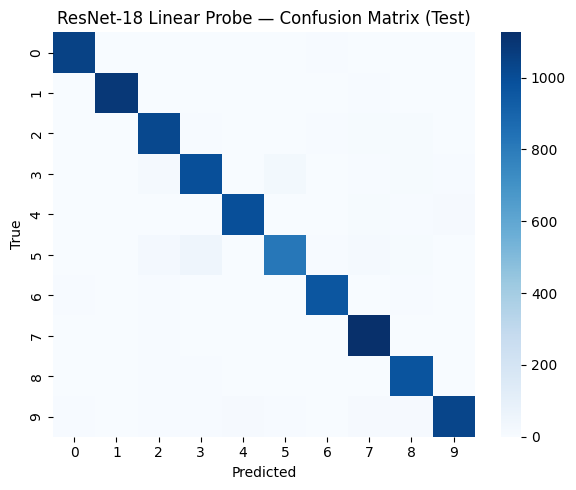

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Collect all predictions
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(1).cpu()
        all_preds.append(preds)
        all_labels.append(yb)

all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
print("\nClassification report (per class):")
print(classification_report(all_labels, all_preds, digits=4))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("ResNet-18 Linear Probe — Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.show()


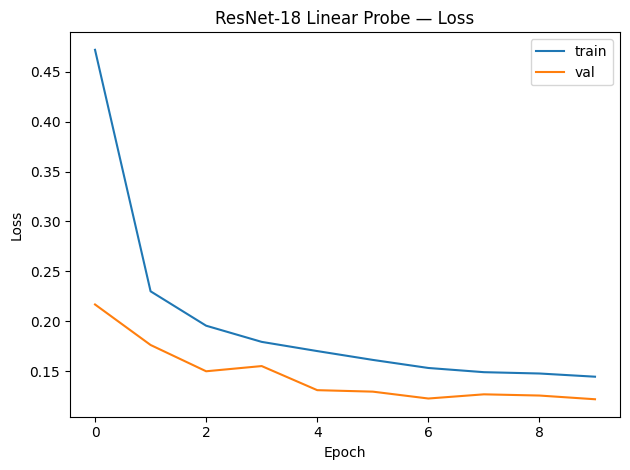

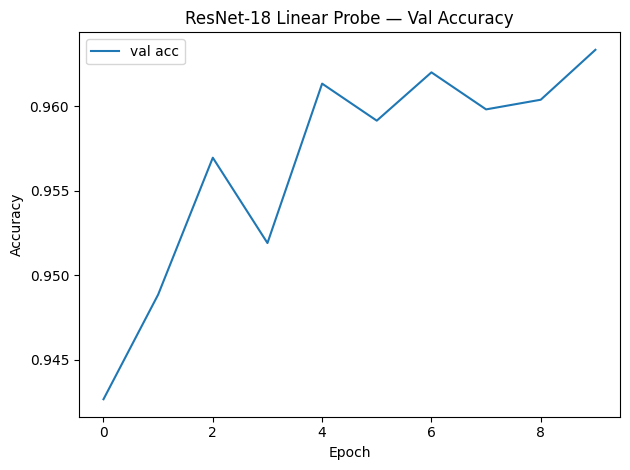

In [9]:
plt.figure()
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'],   label='val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('ResNet-18 Linear Probe — Loss')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(history['val_acc'], label='val acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('ResNet-18 Linear Probe — Val Accuracy')
plt.legend(); plt.tight_layout(); plt.show()


In [10]:
# === Save model and history ===
import os, pickle

os.makedirs("models", exist_ok=True)

# Save model state_dict
model_path = "models/resnet18_linear_probe.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Save training history
losses_path = "models/resnet18_losses.pkl"
with open(losses_path, "wb") as f:
    pickle.dump({
        'train_loss': history['train_loss'],
        'val_loss': history['val_loss'],
        'val_acc': history['val_acc']
    }, f)
print(f"Training history saved to {losses_path}")


Model saved to models/resnet18_linear_probe.pth
Training history saved to models/resnet18_losses.pkl


In [11]:
from google.colab import files
import shutil

# Zip the folder
shutil.make_archive('/content/models', 'zip', '/content/models')

# Download the zip file to your PC
files.download('/content/models.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>